In [1]:
library(mice)
library(finalfit)
library(ggplot2)
library(dplyr)
library(stats)
library(miceadds)
library(cowplot)
library(DMwR2)
# library(Hmisc)
# library(corrplot)
library(fastDummies)

Warning message:
"pakiet 'mice' został zbudowany w wersji R 4.3.2"

Dołączanie pakietu: 'mice'


Następujący obiekt został zakryty z 'package:stats':

    filter


Następujące obiekty zostały zakryte z 'package:base':

    cbind, rbind


Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.3.3"

Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


* miceadds 3.16-18 (2023-01-06 10:54:00)

Warning message:
"pakiet 'cowplot' został zbudowany w wersji R 4.3.2"
Warning message:
"pakiet 'DMwR2' został zbudowany w wersji R 4.3.2"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"pakiet 'fastDummies' został zbudowany w wersji R 4.3.2"
Thank you for using fastDummies!

To acknowledge our work, please cite the package:

Kaplan, J. & Schlegel, B. (2023). fastDummies: Fast 

### Functions definitions

In [2]:
missMAR <- function(data, dependent, explanatory) {
    #' Compute Fisher"s independence test for missingness variable across explanatory variables.
        
    dep_miss <- paste(dependent, "miss", sep="_")
    data[[dep_miss]] <- ifelse(is.na(data[[dependent]]), "Missing", "Not Missing")
    MD <- paste("Missing dependence:", dependent)
    fisher_res <- data.frame(x=character(0), y=character(0))
    colnames(fisher_res) <- c(MD, "p-value")
    
    for (i in 1:length(explanatory)) {
        
        expl <- explanatory[i]
        contingency_tab <- with(data, table(data[[expl]], data[[dep_miss]]))

        pval <- tryCatch({
            p_value <- fisher.test(contingency_tab, simulate.p.value = TRUE)$p.value
            round(p_value, 2)
        }, error = function(e) {
            "no variability"  
        })
        new_row <- data.frame(x=expl, y=as.character(pval))
        colnames(new_row) <- c(MD, "p-value")
        fisher_res <- bind_rows(fisher_res, new_row)
    }

    data <- data[, !(names(data) %in% c(dep_miss))]
    
    return (fisher_res)
}

In [3]:
missPlotCont <- function(data, miss_var, x_var, y_var, title) {
        #' Missingness plot for continuous miss var.

        ggplot(data, aes(x = !!as.name(x_var), y = !!as.name(y_var), colour = !!as.name(miss_var))) +
        geom_point(data = data[data[[miss_var]] == "Not Missing", ], size = 4) +
        geom_point(data = data[data[[miss_var]] == "Missing", ], size = 6) +
        scale_colour_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(title) +
        theme(
        plot.title = element_text(size = 30),
        axis.title = element_text(size = 22),         
        axis.text.x = element_text(size = 18),        
        axis.text.y = element_text(size = 18),
        legend.text = element_text(size = 16),        
        legend.title = element_text(size = 18)
        )
}

In [4]:
missPlotCat <- function(data, miss_var, y_var, wrap_var, title, n_col) {
    #' Missingness plot for continuous miss var.

    p <- ggplot(data, aes(x = "", y = !!as.name(y_var), fill = !!as.name(miss_var))) +
        geom_bar(stat = "identity", width=1) +
        coord_polar("y", start=0) +
        scale_fill_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(title) +
        theme(
            plot.title = element_text(size = 30),
            axis.title = element_blank(),         
            axis.text.x = element_blank(),        
            axis.text.y = element_blank(),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18),
            strip.text = element_text(size = 22),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank()
            )

    p + facet_wrap(~ get(wrap_var), ncol = n_col)

}

In [5]:
hep <- read.csv("hepatitis.csv")
hep[] <- lapply(hep, function(x) ifelse(x == "", NA, x))

In [6]:
fcols <- names(which(sapply(hep, is.character)))
hep[fcols] <- hep[fcols] %>% lapply(factor)

In [7]:
ff_glimpse(hep)

Warning message:
"`fct_explicit_na()` was deprecated in forcats 1.0.0.
ℹ Please use `fct_na_value_to_level()` instead.
ℹ The deprecated feature was likely used in the finalfit package.
  Please report the issue at <https://github.com/ewenharrison/finalfit/issues>."


$Continuous
                      label var_type   n missing_n missing_percent  mean   sd
age                     age    <int> 155         0             0.0  41.2 12.6
bilirubin         bilirubin    <dbl> 149         6             3.9   1.4  1.2
alk_phosphate alk_phosphate    <int> 126        29            18.7 105.3 51.5
sgot                   sgot    <int> 151         4             2.6  85.9 89.7
albumin             albumin    <dbl> 139        16            10.3   3.8  0.7
protime             protime    <int>  88        67            43.2  61.9 22.9
               min quartile_25 median quartile_75   max
age            7.0        32.0   39.0        50.0  78.0
bilirubin      0.3         0.7    1.0         1.5   8.0
alk_phosphate 26.0        74.2   85.0       132.2 295.0
sgot          14.0        31.5   58.0       100.5 648.0
albumin        2.1         3.4    4.0         4.2   6.4
protime        0.0        46.0   61.0        76.2 100.0

$Categorical
                          label var_type   n missing_n missing_percent levels_n
sex                         sex    <fct> 155         0             0.0        2
steroid                 steroid    <fct> 154         1             0.6        2
antivirals           antivirals    <fct> 155         0             0.0        2
fatigue                 fatigue    <fct> 154         1             0.6        2
malaise                 malaise    <fct> 154         1             0.6        2
anorexia               anorexia    <fct> 154         1             0.6        2
liver_big             liver_big    <fct> 145        10             6.5        2
liver_firm           liver_firm    <fct> 144        11             7.1        2
spleen_palpable spleen_palpable    <fct> 150         5             3.2        2
spiders                 spiders    <fct> 150         5             3.2        2
ascites                 ascites    <fct> 150         5             3.2        2
varices                 varices    <fct> 150         5             3.2        2
histology             histology    <fct> 155         0             0.0        2
class                     class    <fct> 155         0             0.0        2
                                      levels levels_count      levels_percent
sex                         "female", "male"      139, 16              90, 10
steroid         "False", "True", "(Missing)"    76, 78, 1 49.03, 50.32,  0.65
antivirals                   "False", "True"      131, 24              85, 15
fatigue         "False", "True", "(Missing)"   54, 100, 1 34.84, 64.52,  0.65
malaise         "False", "True", "(Missing)"    93, 61, 1 60.00, 39.35,  0.65
anorexia        "False", "True", "(Missing)"   122, 32, 1 78.71, 20.65,  0.65
liver_big       "False", "True", "(Missing)"  25, 120, 10    16.1, 77.4,  6.5
liver_firm      "False", "True", "(Missing)"   84, 60, 11    54.2, 38.7,  7.1
spleen_palpable "False", "True", "(Missing)"   120, 30, 5    77.4, 19.4,  3.2
spiders         "False", "True", "(Missing)"    99, 51, 5    63.9, 32.9,  3.2
ascites         "False", "True", "(Missing)"   130, 20, 5    83.9, 12.9,  3.2
varices         "False", "True", "(Missing)"   132, 18, 5    85.2, 11.6,  3.2
histology                    "False", "True"       85, 70              55, 45
class                          "die", "live"      32, 123              21, 79

In [7]:
TFcols <- fcols[-c(1, 14)]

for (col in TFcols) {
    hep[[col]] <- case_when(hep[[col]]=="True" ~ "1", hep[[col]]=="False" ~ "0", TRUE ~ NA)
}

hep$male <- ifelse(hep$sex=="male", "1", "0")
hep$die <- ifelse(hep$class=="die", "1", "0")
fcols[1] <- "male"
fcols[14] <- "die"
hep[fcols] <- hep[fcols] %>% lapply(factor)
hep <- subset(hep, select=-c(sex, class))

In [35]:
ff_glimpse(hep)

$Continuous
                      label var_type   n missing_n missing_percent  mean   sd
age                     age    <int> 155         0             0.0  41.2 12.6
bilirubin         bilirubin    <dbl> 149         6             3.9   1.4  1.2
alk_phosphate alk_phosphate    <int> 126        29            18.7 105.3 51.5
sgot                   sgot    <int> 151         4             2.6  85.9 89.7
albumin             albumin    <dbl> 139        16            10.3   3.8  0.7
protime             protime    <int>  88        67            43.2  61.9 22.9
               min quartile_25 median quartile_75   max
age            7.0        32.0   39.0        50.0  78.0
bilirubin      0.3         0.7    1.0         1.5   8.0
alk_phosphate 26.0        74.2   85.0       132.2 295.0
sgot          14.0        31.5   58.0       100.5 648.0
albumin        2.1         3.4    4.0         4.2   6.4
protime        0.0        46.0   61.0        76.2 100.0

$Categorical
                          label var_type   n missing_n missing_percent levels_n
steroid                 steroid    <fct> 154         1             0.6        2
antivirals           antivirals    <fct> 155         0             0.0        2
fatigue                 fatigue    <fct> 154         1             0.6        2
malaise                 malaise    <fct> 154         1             0.6        2
anorexia               anorexia    <fct> 154         1             0.6        2
liver_big             liver_big    <fct> 145        10             6.5        2
liver_firm           liver_firm    <fct> 144        11             7.1        2
spleen_palpable spleen_palpable    <fct> 150         5             3.2        2
spiders                 spiders    <fct> 150         5             3.2        2
ascites                 ascites    <fct> 150         5             3.2        2
varices                 varices    <fct> 150         5             3.2        2
histology             histology    <fct> 155         0             0.0        2
male                       male    <fct> 155         0             0.0        2
die                         die    <fct> 155         0             0.0        2
                               levels levels_count      levels_percent
steroid         "0", "1", "(Missing)"    76, 78, 1 49.03, 50.32,  0.65
antivirals                   "0", "1"      131, 24              85, 15
fatigue         "0", "1", "(Missing)"   54, 100, 1 34.84, 64.52,  0.65
malaise         "0", "1", "(Missing)"    93, 61, 1 60.00, 39.35,  0.65
anorexia        "0", "1", "(Missing)"   122, 32, 1 78.71, 20.65,  0.65
liver_big       "0", "1", "(Missing)"  25, 120, 10    16.1, 77.4,  6.5
liver_firm      "0", "1", "(Missing)"   84, 60, 11    54.2, 38.7,  7.1
spleen_palpable "0", "1", "(Missing)"   120, 30, 5    77.4, 19.4,  3.2
spiders         "0", "1", "(Missing)"    99, 51, 5    63.9, 32.9,  3.2
ascites         "0", "1", "(Missing)"   130, 20, 5    83.9, 12.9,  3.2
varices         "0", "1", "(Missing)"   132, 18, 5    85.2, 11.6,  3.2
histology                    "0", "1"       85, 70              55, 45
male                         "0", "1"      139, 16              90, 10
die                          "0", "1"      123, 32              79, 21

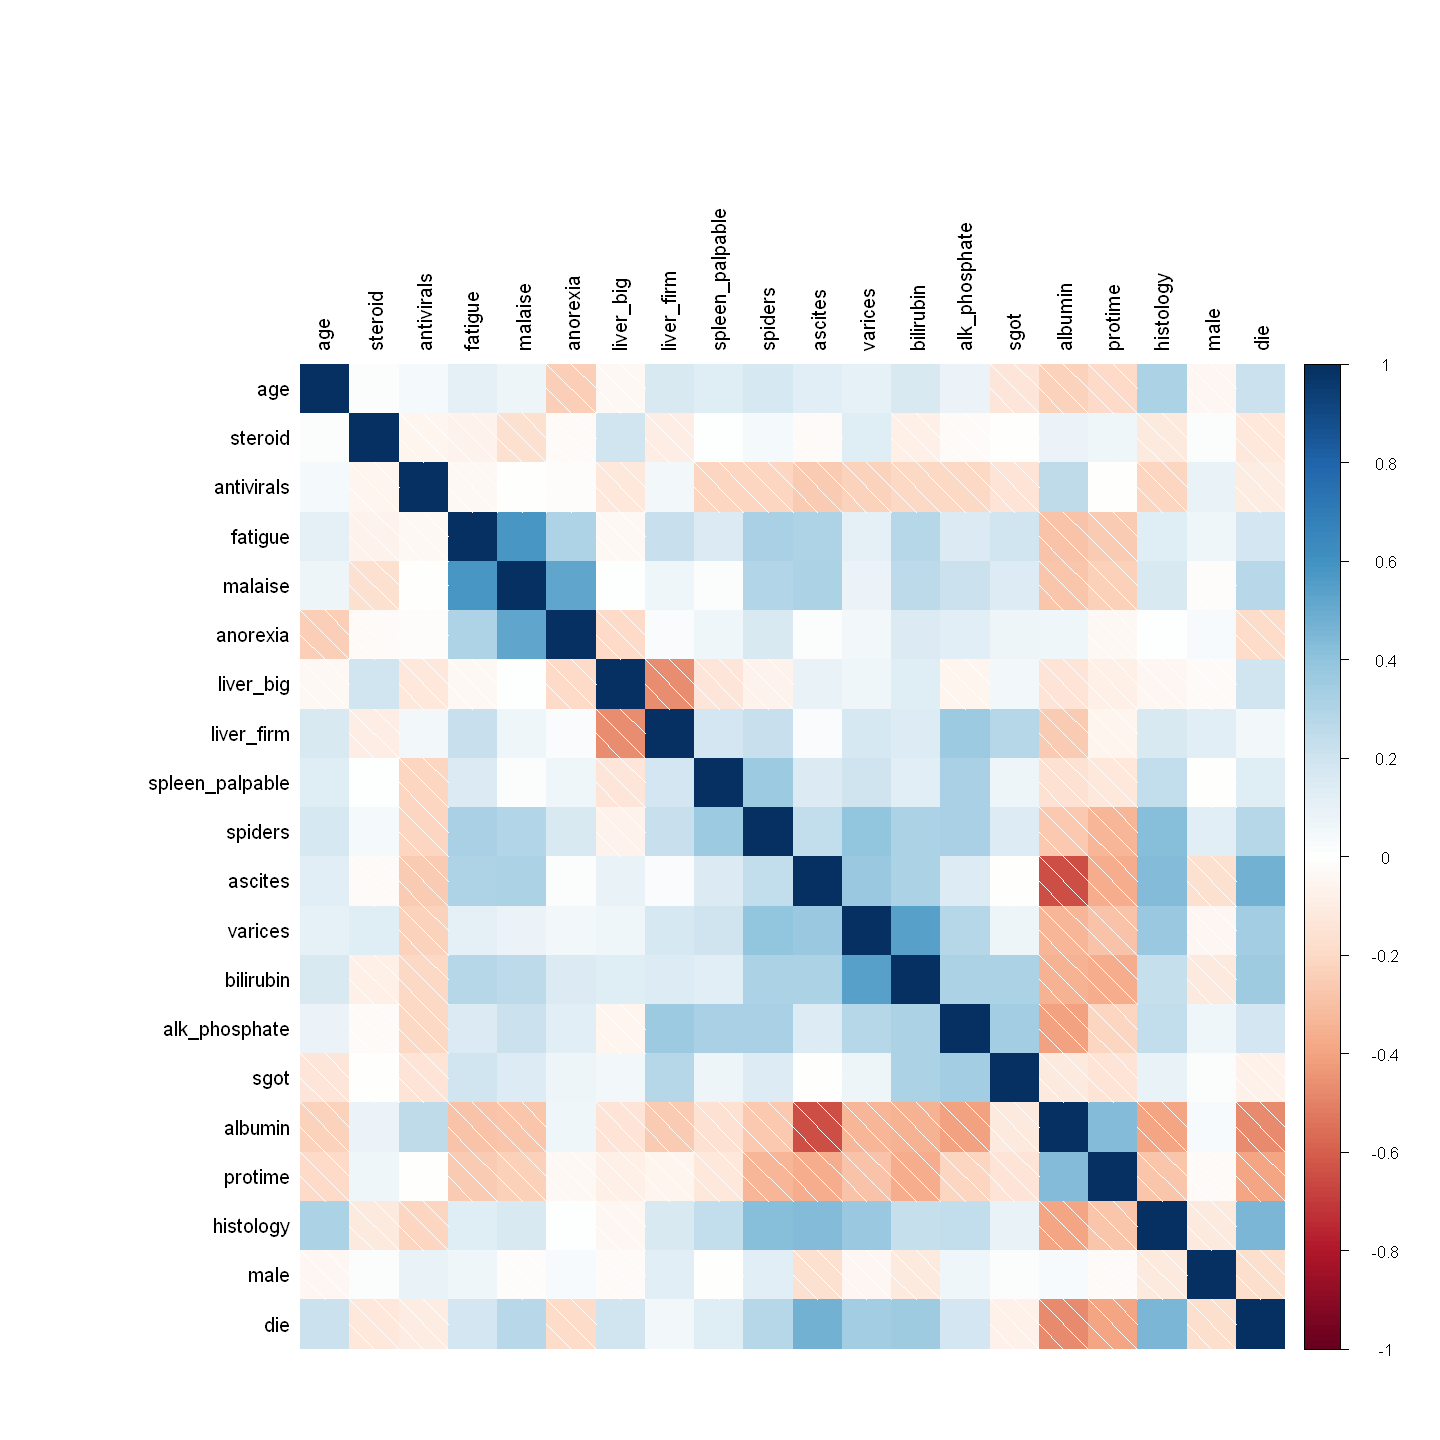

In [37]:
# corrm <- rcorr(as.matrix(na.omit(hep)))$r
# options(repr.plot.width = 12, repr.plot.height = 12)
# corrplot(corrm, tl.col="black", method="shade")

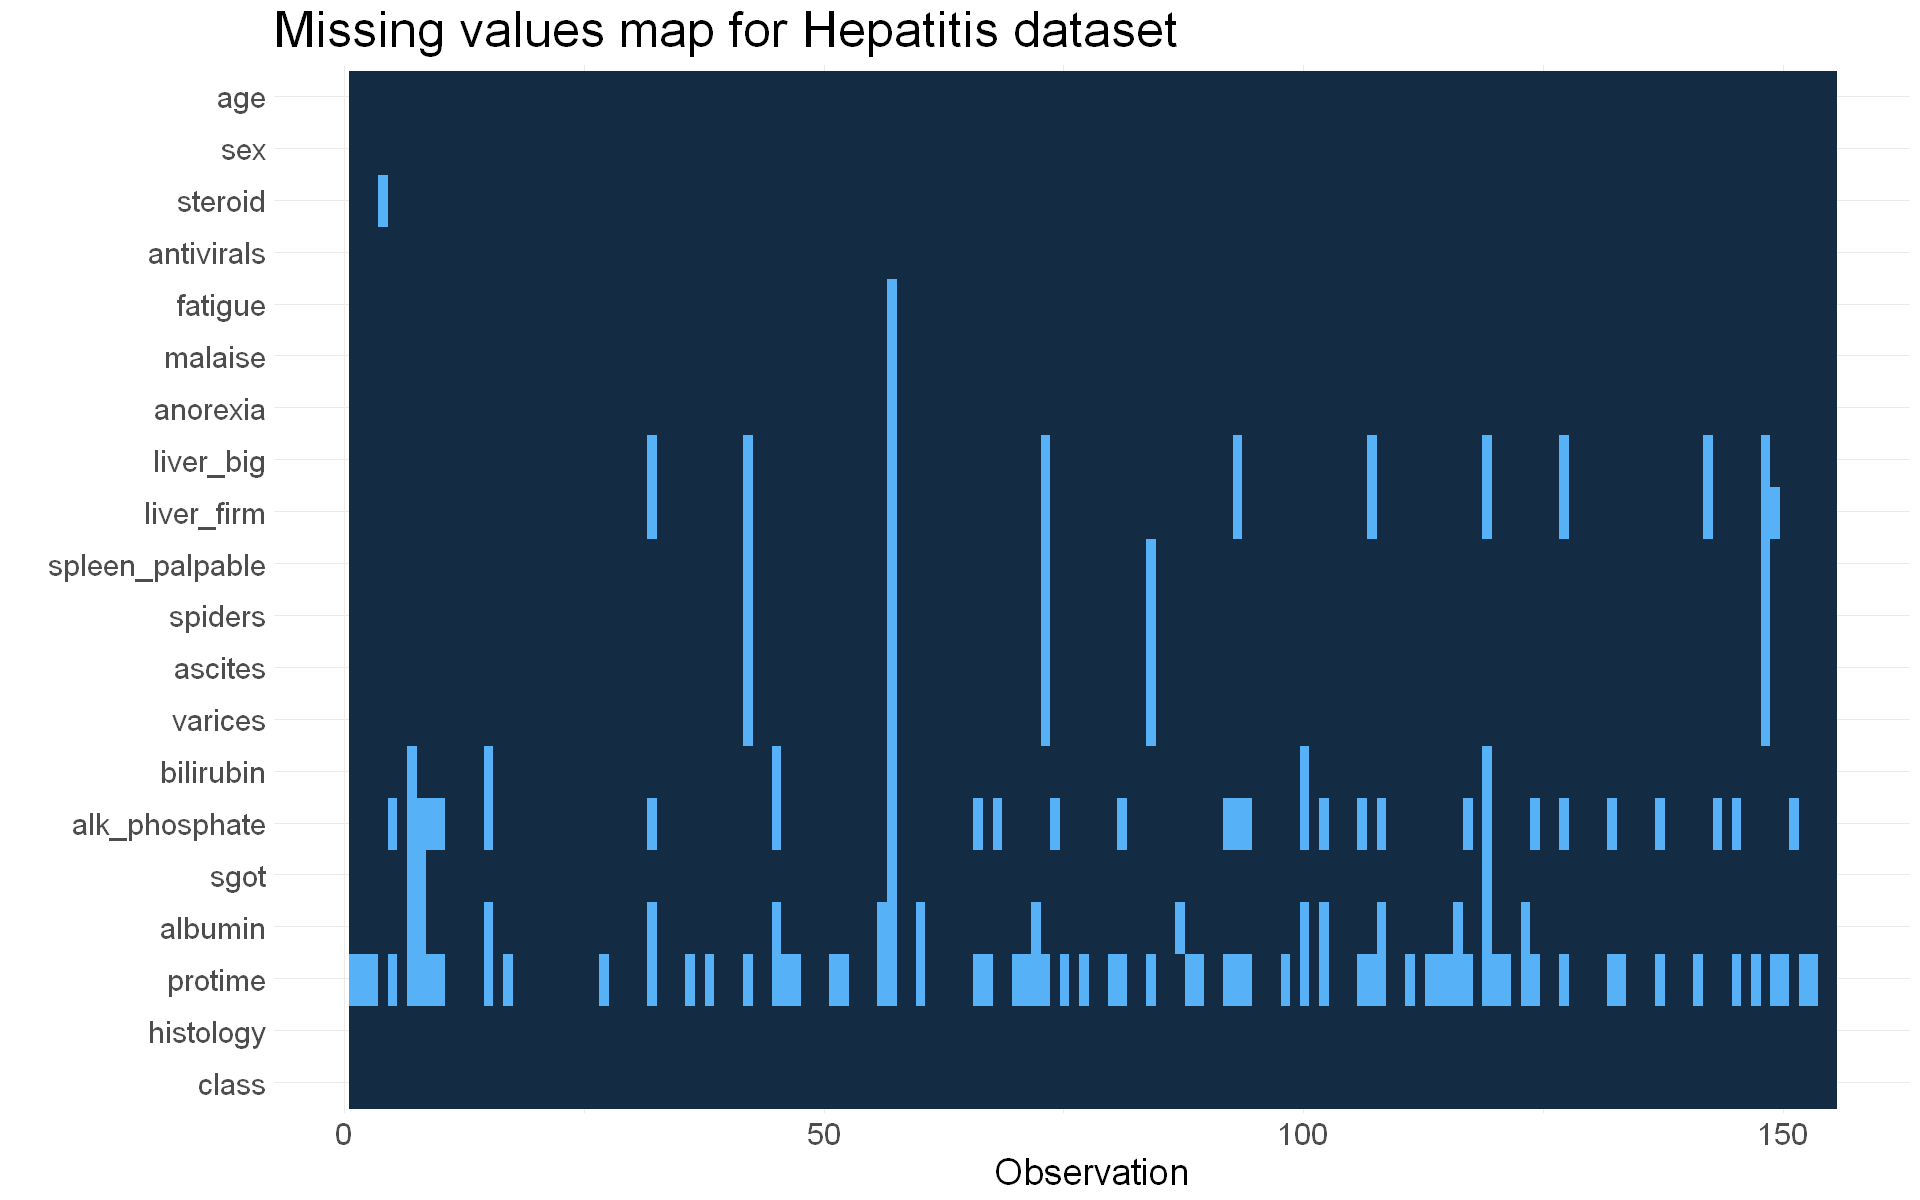

In [129]:
options(repr.plot.width = 16, repr.plot.height = 10)

miss_plot <- hep %>% missing_plot()

miss_plot <- miss_plot +
    theme(
        plot.title = element_text(size = 30),         
        axis.title = element_text(size = 22),         
        axis.text.x = element_text(size = 18),        
        axis.text.y = element_text(size = 18)) +
    labs(title = "Missing values map for Hepatitis dataset")
 
miss_plot

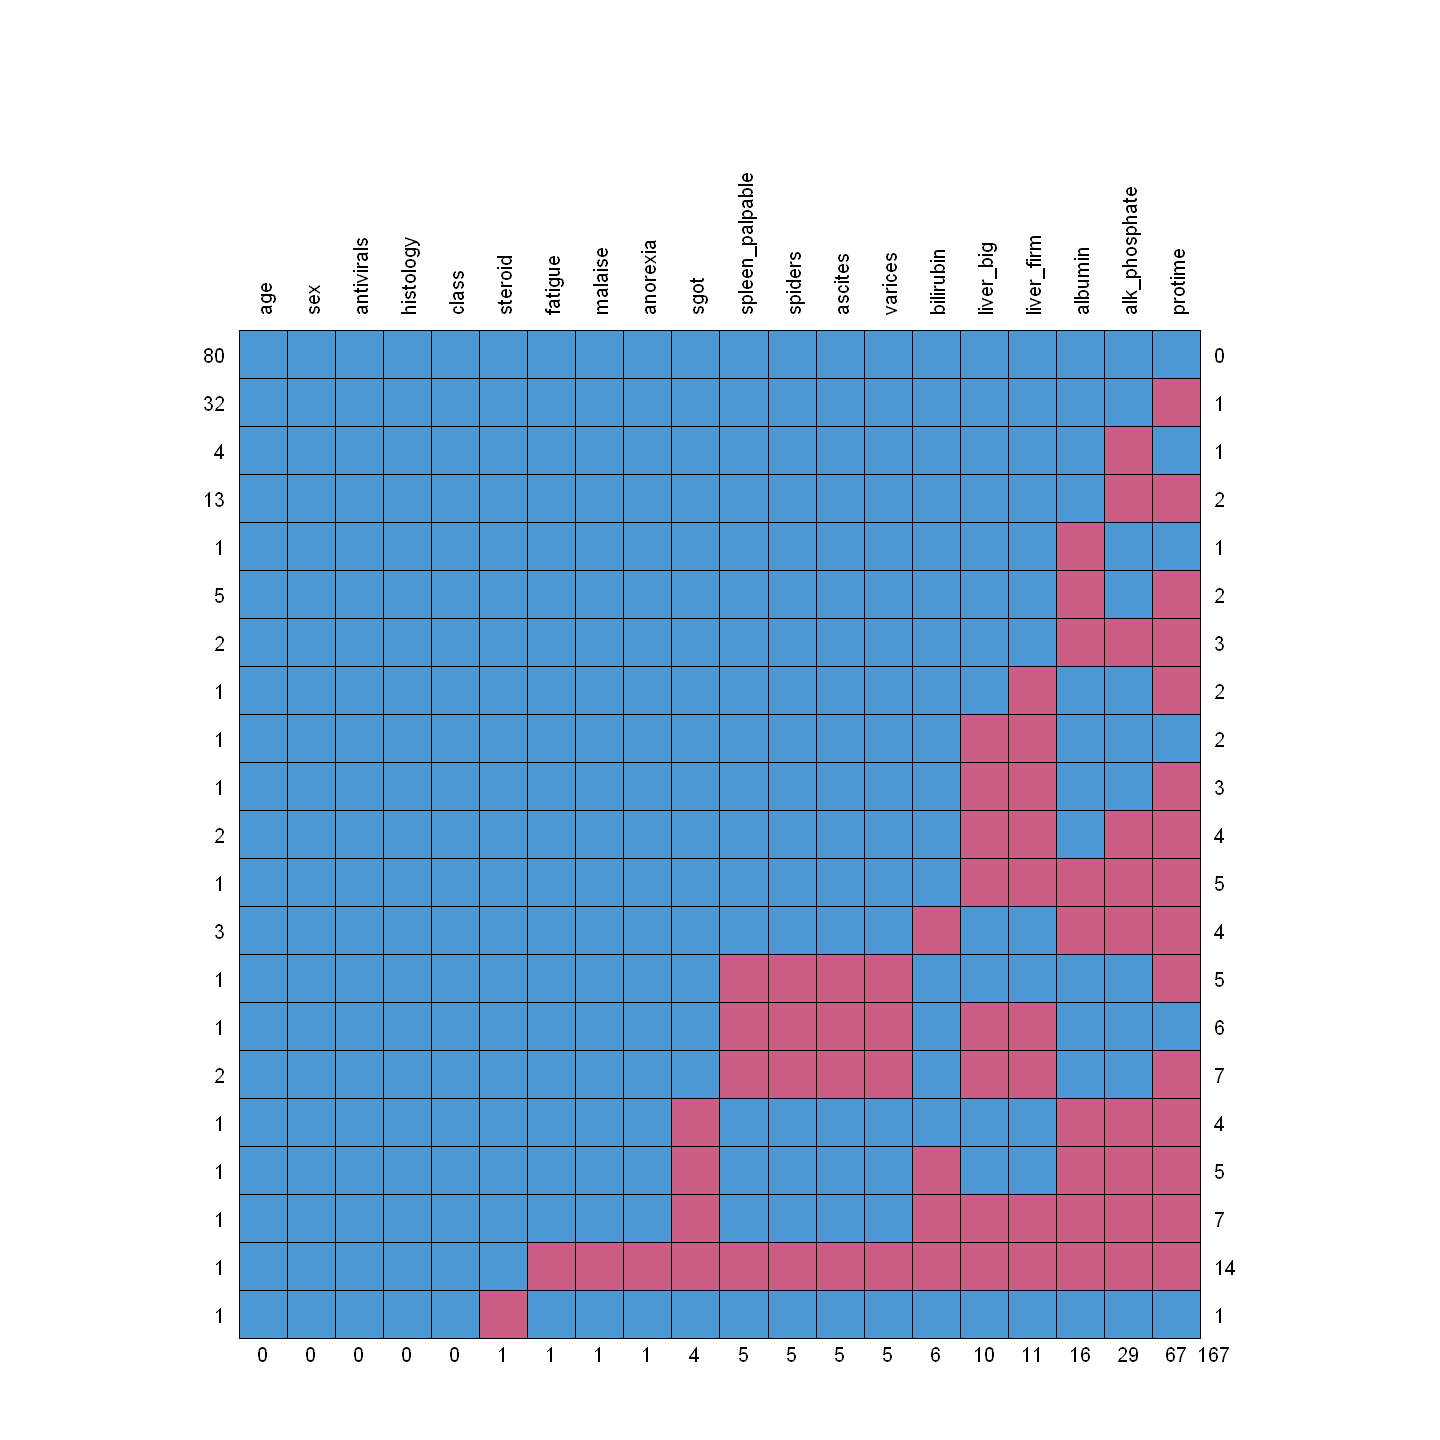

In [144]:
options(repr.plot.width = 12, repr.plot.height = 12)
hep_pattern <- md.pattern(hep, rotate.names=TRUE)

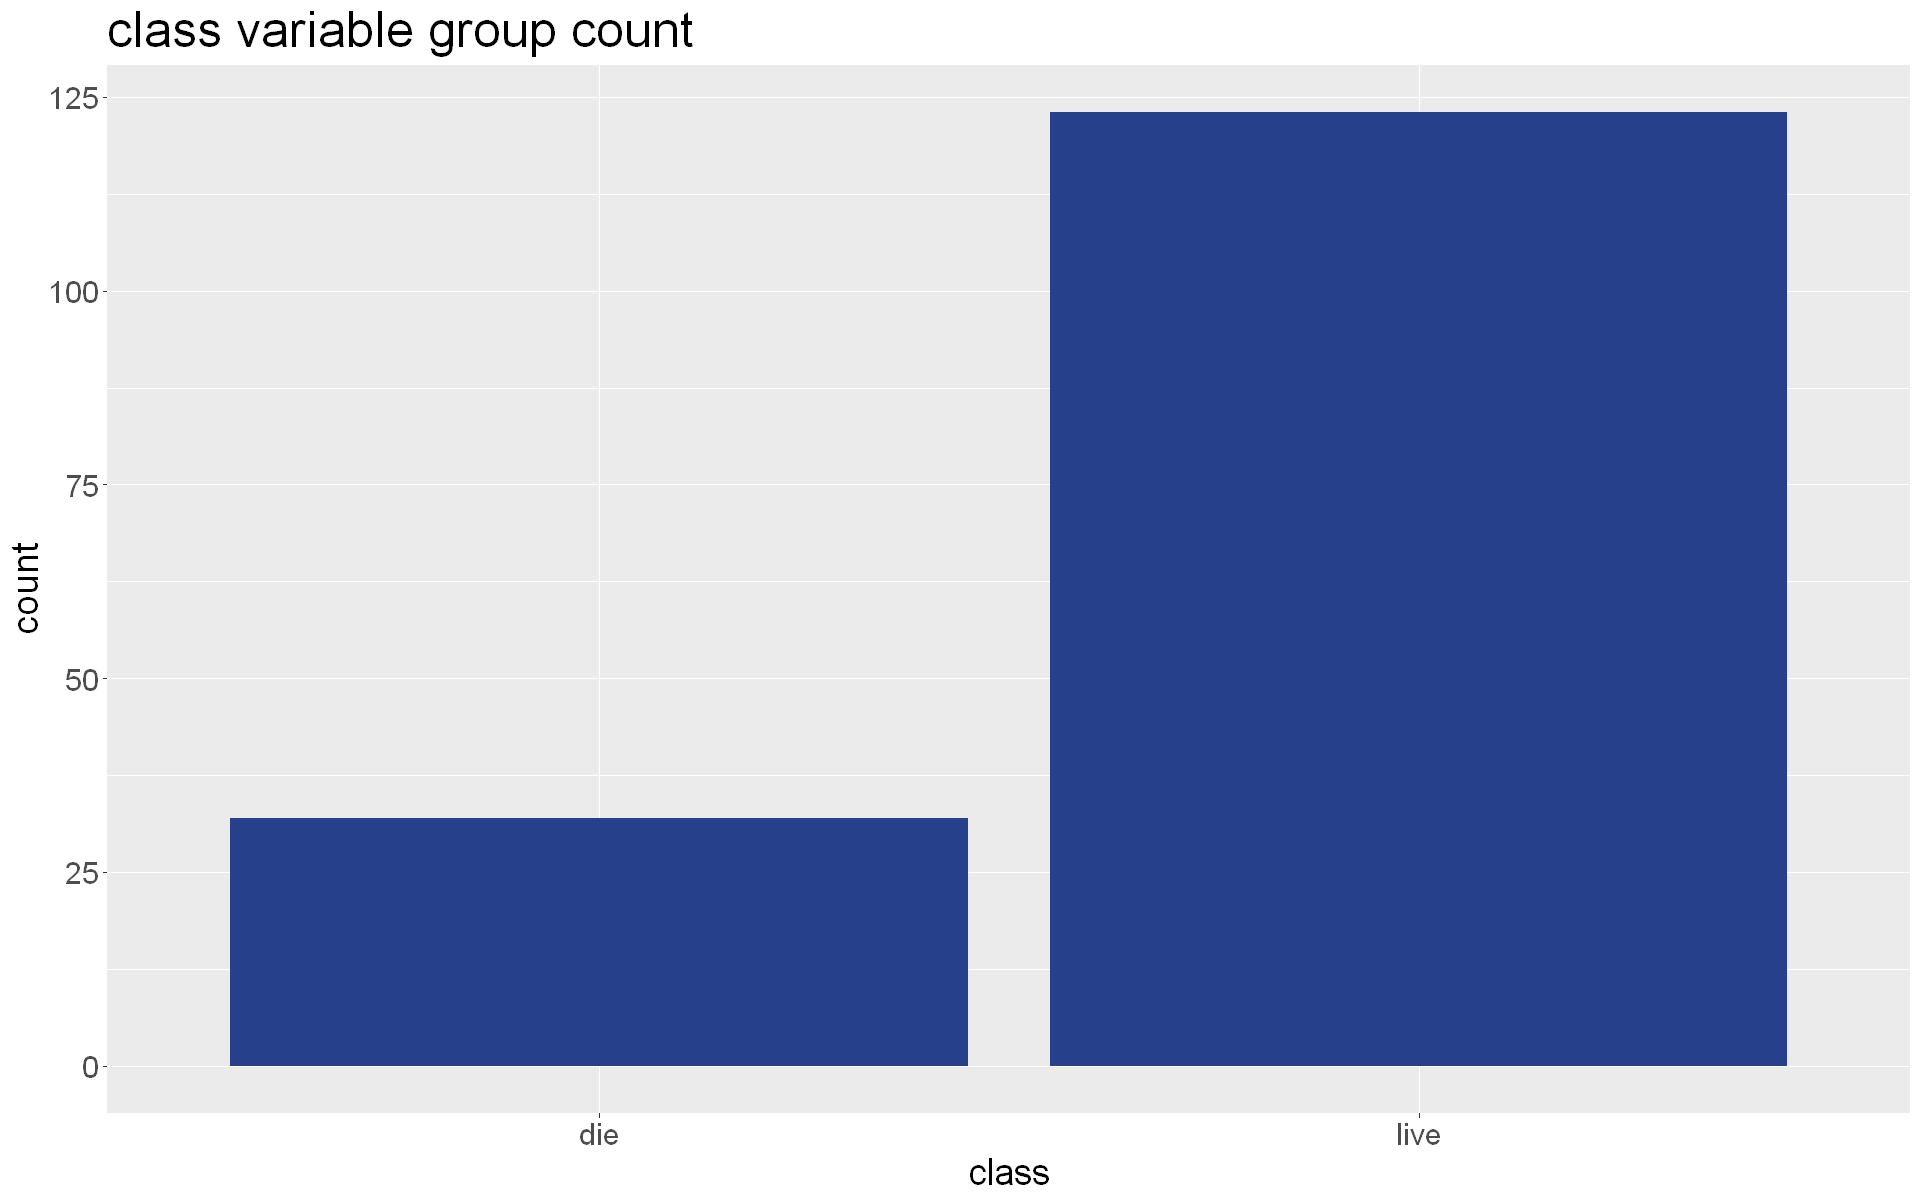

In [107]:
options(repr.plot.width = 16, repr.plot.height = 10)

ggplot(hep, aes(x=class)) +
    geom_bar(fill="royalblue4") +
    ggtitle("class variable group count") +
    theme(
        plot.title = element_text(size = 30),
        axis.title = element_text(size = 22),         
        axis.text.x = element_text(size = 18),        
        axis.text.y = element_text(size = 18)
        )

In [42]:
dependent <- "bilirubin"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: bilirubin,p-value
<chr>,<chr>
age,0.42
steroid,0.11
antivirals,1
fatigue,1
malaise,0.65
anorexia,1
liver_big,0.54
liver_firm,0.64
spleen_palpable,0.26


In [43]:
dependent <- "alk_phosphate"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: alk_phosphate,p-value
<chr>,<chr>
age,0.74
steroid,0.68
antivirals,0.05
fatigue,0.66
malaise,1
anorexia,0.04
liver_big,0.25
liver_firm,0.02
spleen_palpable,1


In [44]:
dependent <- "sgot"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: sgot,p-value
<chr>,<chr>
age,0.81
steroid,0.36
antivirals,1
fatigue,1
malaise,1
anorexia,0.51
liver_big,1
liver_firm,0.51
spleen_palpable,0.49


In [45]:
dependent <- "albumin"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: albumin,p-value
<chr>,<chr>
age,0.28
steroid,0.12
antivirals,0.47
fatigue,1
malaise,0.59
anorexia,1
liver_big,1
liver_firm,0.07
spleen_palpable,0.18


In [46]:
dependent <- "protime"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: protime,p-value
<chr>,<chr>
age,0.78
steroid,0.87
antivirals,0
fatigue,0.61
malaise,0.51
anorexia,0.42
liver_big,0.5
liver_firm,0.17
spleen_palpable,0.84


In [47]:
dependent <- "steroid"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: steroid,p-value
<chr>,<chr>
age,0.5
antivirals,0.15
fatigue,0.35
malaise,1
anorexia,1
liver_big,1
liver_firm,1
spleen_palpable,1
spiders,1


In [48]:
dependent <- "fatigue"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: fatigue,p-value
<chr>,<chr>
age,1
steroid,0.49
antivirals,1
malaise,1
anorexia,1
liver_big,1
liver_firm,1
spleen_palpable,1
spiders,1


In [49]:
dependent <- "malaise"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: malaise,p-value
<chr>,<chr>
age,1
steroid,0.49
antivirals,1
fatigue,1
anorexia,1
liver_big,1
liver_firm,1
spleen_palpable,1
spiders,1


In [50]:
dependent <- "anorexia"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: anorexia,p-value
<chr>,<chr>
age,1
steroid,0.49
antivirals,1
fatigue,1
malaise,1
liver_big,1
liver_firm,1
spleen_palpable,1
spiders,1


In [51]:
dependent <- "liver_big"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: liver_big,p-value
<chr>,<chr>
age,0.33
steroid,0.53
antivirals,0.36
fatigue,0.5
malaise,0.16
anorexia,0.39
liver_firm,1
spleen_palpable,0.34
spiders,0.41


In [52]:
dependent <- "liver_firm"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: liver_firm,p-value
<chr>,<chr>
age,0.34
steroid,0.37
antivirals,0.22
fatigue,1
malaise,0.2
anorexia,0.43
liver_big,1
spleen_palpable,0.63
spiders,0.69


In [53]:
dependent <- "spleen_palpable"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: spleen_palpable,p-value
<chr>,<chr>
age,0.15
steroid,0.68
antivirals,1
fatigue,1
malaise,0.3
anorexia,0.19
liver_big,1
liver_firm,1
spiders,1


In [54]:
dependent <- "spiders"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: spiders,p-value
<chr>,<chr>
age,0.15
steroid,0.68
antivirals,1
fatigue,1
malaise,0.3
anorexia,0.19
liver_big,1
liver_firm,1
spleen_palpable,1


In [55]:
dependent <- "ascites"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: ascites,p-value
<chr>,<chr>
age,0.16
steroid,0.68
antivirals,1
fatigue,1
malaise,0.3
anorexia,0.19
liver_big,1
liver_firm,1
spleen_palpable,1


In [56]:
dependent <- "varices"
explanatory <- setdiff(colnames(hep), dependent)
missMAR(hep, dependent, explanatory)

Missing dependence: varices,p-value
<chr>,<chr>
age,0.16
steroid,0.68
antivirals,1
fatigue,1
malaise,0.3
anorexia,0.19
liver_big,1
liver_firm,1
spleen_palpable,1


In [8]:
hep <- hep %>%
  filter(!is.na(bilirubin) & !is.na(sgot) & !is.na(fatigue) & !is.na(malaise) & !is.na(anorexia))

In [58]:
write.csv(hep, "hepatitis2.csv", row.names = FALSE)

In [59]:
ff_glimpse(hep)

$Continuous
                      label var_type   n missing_n missing_percent  mean   sd
age                     age    <int> 148         0             0.0  41.1 12.5
bilirubin         bilirubin    <dbl> 148         0             0.0   1.4  1.2
alk_phosphate alk_phosphate    <int> 126        22            14.9 105.3 51.5
sgot                   sgot    <int> 148         0             0.0  86.4 90.5
albumin             albumin    <dbl> 139         9             6.1   3.8  0.7
protime             protime    <int>  88        60            40.5  61.9 22.9
               min quartile_25 median quartile_75   max
age            7.0        32.0   39.0        50.0  78.0
bilirubin      0.3         0.7    1.0         1.5   8.0
alk_phosphate 26.0        74.2   85.0       132.2 295.0
sgot          14.0        31.0   58.0       103.2 648.0
albumin        2.1         3.4    4.0         4.2   6.4
protime        0.0        46.0   61.0        76.2 100.0

$Categorical
                          label var_type   n missing_n missing_percent levels_n
steroid                 steroid    <fct> 147         1             0.7        2
antivirals           antivirals    <fct> 148         0             0.0        2
fatigue                 fatigue    <fct> 148         0             0.0        2
malaise                 malaise    <fct> 148         0             0.0        2
anorexia               anorexia    <fct> 148         0             0.0        2
liver_big             liver_big    <fct> 140         8             5.4        2
liver_firm           liver_firm    <fct> 139         9             6.1        2
spleen_palpable spleen_palpable    <fct> 144         4             2.7        2
spiders                 spiders    <fct> 144         4             2.7        2
ascites                 ascites    <fct> 144         4             2.7        2
varices                 varices    <fct> 144         4             2.7        2
histology             histology    <fct> 148         0             0.0        2
male                       male    <fct> 148         0             0.0        2
die                         die    <fct> 148         0             0.0        2
                               levels levels_count      levels_percent
steroid         "0", "1", "(Missing)"    71, 76, 1 47.97, 51.35,  0.68
antivirals                   "0", "1"      125, 23              84, 16
fatigue                      "0", "1"       51, 97              34, 66
malaise                      "0", "1"       88, 60              59, 41
anorexia                     "0", "1"      117, 31              79, 21
liver_big       "0", "1", "(Missing)"   24, 116, 8    16.2, 78.4,  5.4
liver_firm      "0", "1", "(Missing)"    80, 59, 9    54.1, 39.9,  6.1
spleen_palpable "0", "1", "(Missing)"   116, 28, 4    78.4, 18.9,  2.7
spiders         "0", "1", "(Missing)"    96, 48, 4    64.9, 32.4,  2.7
ascites         "0", "1", "(Missing)"   124, 20, 4    83.8, 13.5,  2.7
varices         "0", "1", "(Missing)"   126, 18, 4    85.1, 12.2,  2.7
histology                    "0", "1"       80, 68              54, 46
male                         "0", "1"      132, 16              89, 11
die                          "0", "1"      118, 30              80, 20

`summarise()` has grouped output by 'anorexia'. You can override using the
`.groups` argument.


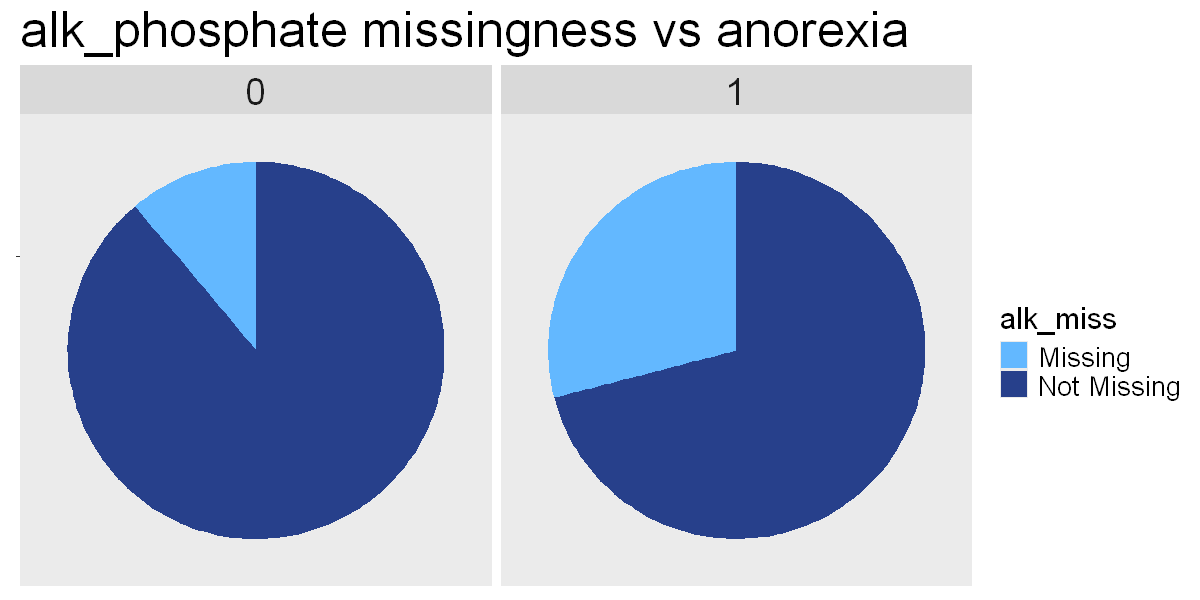

In [11]:
options(repr.plot.width = 10, repr.plot.height = 5)

hep$alk_miss <- ifelse(is.na(hep$alk_phosphate), "Missing", "Not Missing")

ano_freq <- hep %>%
    group_by(anorexia, alk_miss) %>%
    summarize(count = n()) %>%
    mutate(freq = count/sum(count))

missPlotCat(ano_freq, "alk_miss", "freq", "anorexia", "alk_phosphate missingness vs anorexia", 2)

`summarise()` has grouped output by 'liver_firm'. You can override using the
`.groups` argument.


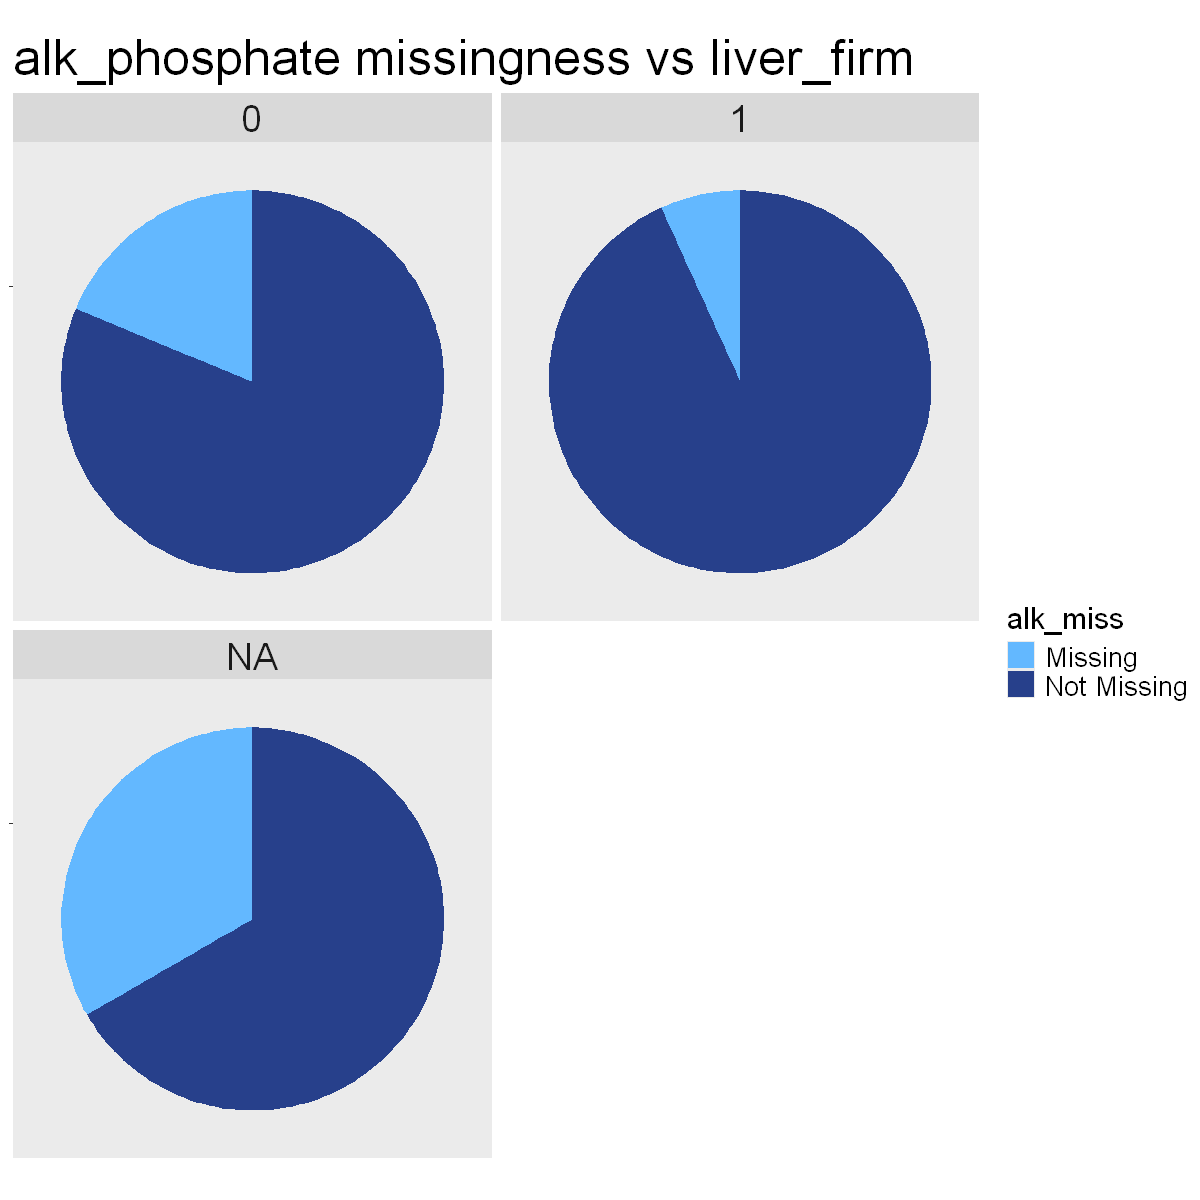

In [14]:
options(repr.plot.width = 10, repr.plot.height = 10)

liv_freq <- hep %>%
    group_by(liver_firm, alk_miss) %>%
    summarize(count = n()) %>%
    mutate(freq = count/sum(count))

missPlotCat(liv_freq, "alk_miss", "freq", "liver_firm", "alk_phosphate missingness vs liver_firm", 2)

`summarise()` has grouped output by 'male'. You can override using the
`.groups` argument.


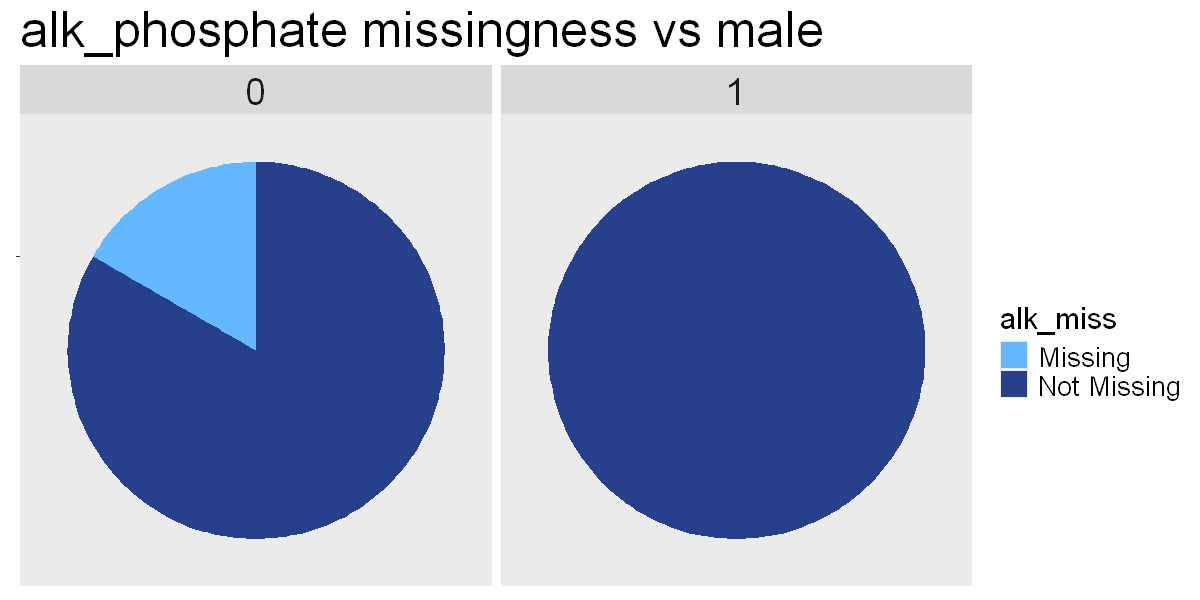

In [16]:
options(repr.plot.width = 10, repr.plot.height = 5)

male_freq <- hep %>%
    group_by(male, alk_miss) %>%
    summarize(count = n()) %>%
    mutate(freq = count/sum(count))

missPlotCat(male_freq, "alk_miss", "freq", "male", "alk_phosphate missingness vs male", 2)

`summarise()` has grouped output by 'die'. You can override using the `.groups`
argument.


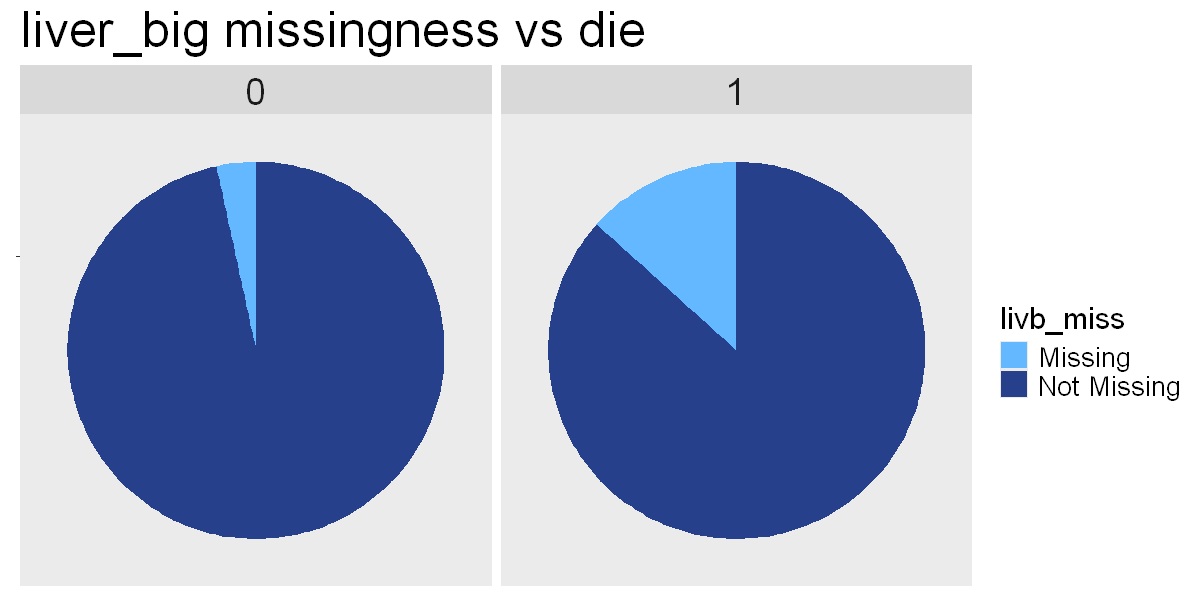

In [17]:
options(repr.plot.width = 10, repr.plot.height = 5)

hep$livb_miss <- ifelse(is.na(hep$liver_big), "Missing", "Not Missing")

die_freq <- hep %>%
    group_by(die, livb_miss) %>%
    summarize(count = n()) %>%
    mutate(freq = count/sum(count))

missPlotCat(die_freq, "livb_miss", "freq", "die", "liver_big missingness vs die", 2)